In [1]:
!pip install pydicom
!pip install pylidc
!pip install torchsummary

     |████████████████████████████████| 2.0 MB 7.5 MB/s eta 0:00:01
     |████████████████████████████████| 5.6 MB 6.1 MB/s eta 0:00:01
     |████████████████████████████████| 30.2 MB 41.1 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 57.9 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 57.0 MB/s eta 0:00:01
     |████████████████████████████████| 171 kB 68.9 MB/s eta 0:00:01
     |████████████████████████████████| 4.4 MB 92.3 MB/s eta 0:00:01
     |████████████████████████████████| 156 kB 74.5 MB/s eta 0:00:01


In [3]:
import pylidc as pl
from pylidc.utils import consensus
import pydicom as dicom
from skimage.measure import find_contours
import numpy as np
import matplotlib.pyplot as plt
import os
from numpy import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import torchvision
import time
from torch.nn.parallel import DistributedDataParallel as DDP

### Set up the configuration for pylidc

In [5]:
data_folder = '/data/downloaded_small_lidc_sorted/'

In [6]:
f = open ('/root/.pylidcrc','w')            #For GCP, Linux, Linux in Docker 
#f = open ('/home/root/.pylidcrc','w')    #For Colab
f.write('[dicom]'+'\n')
f.write('path =' + data_folder +'\n')
f.write('warn = True')
f.close()

In [4]:
ls /data/downloaded_small_lidc_sorted/

LIDC-IDRI-0069/  LIDC-IDRI-0086/  LIDC-IDRI-0101/  LIDC-IDRI-0314/
LIDC-IDRI-0078/  LIDC-IDRI-0094/  LIDC-IDRI-0106/  LIDC-IDRI-0325/
LIDC-IDRI-0079/  LIDC-IDRI-0095/  LIDC-IDRI-0298/  LIDC-IDRI-0345/
LIDC-IDRI-0084/  LIDC-IDRI-0098/  LIDC-IDRI-0300/


#### Examine some images and masks

Current patient ID = LIDC-IDRI-0086
Loading dicom files ... This may take a moment.


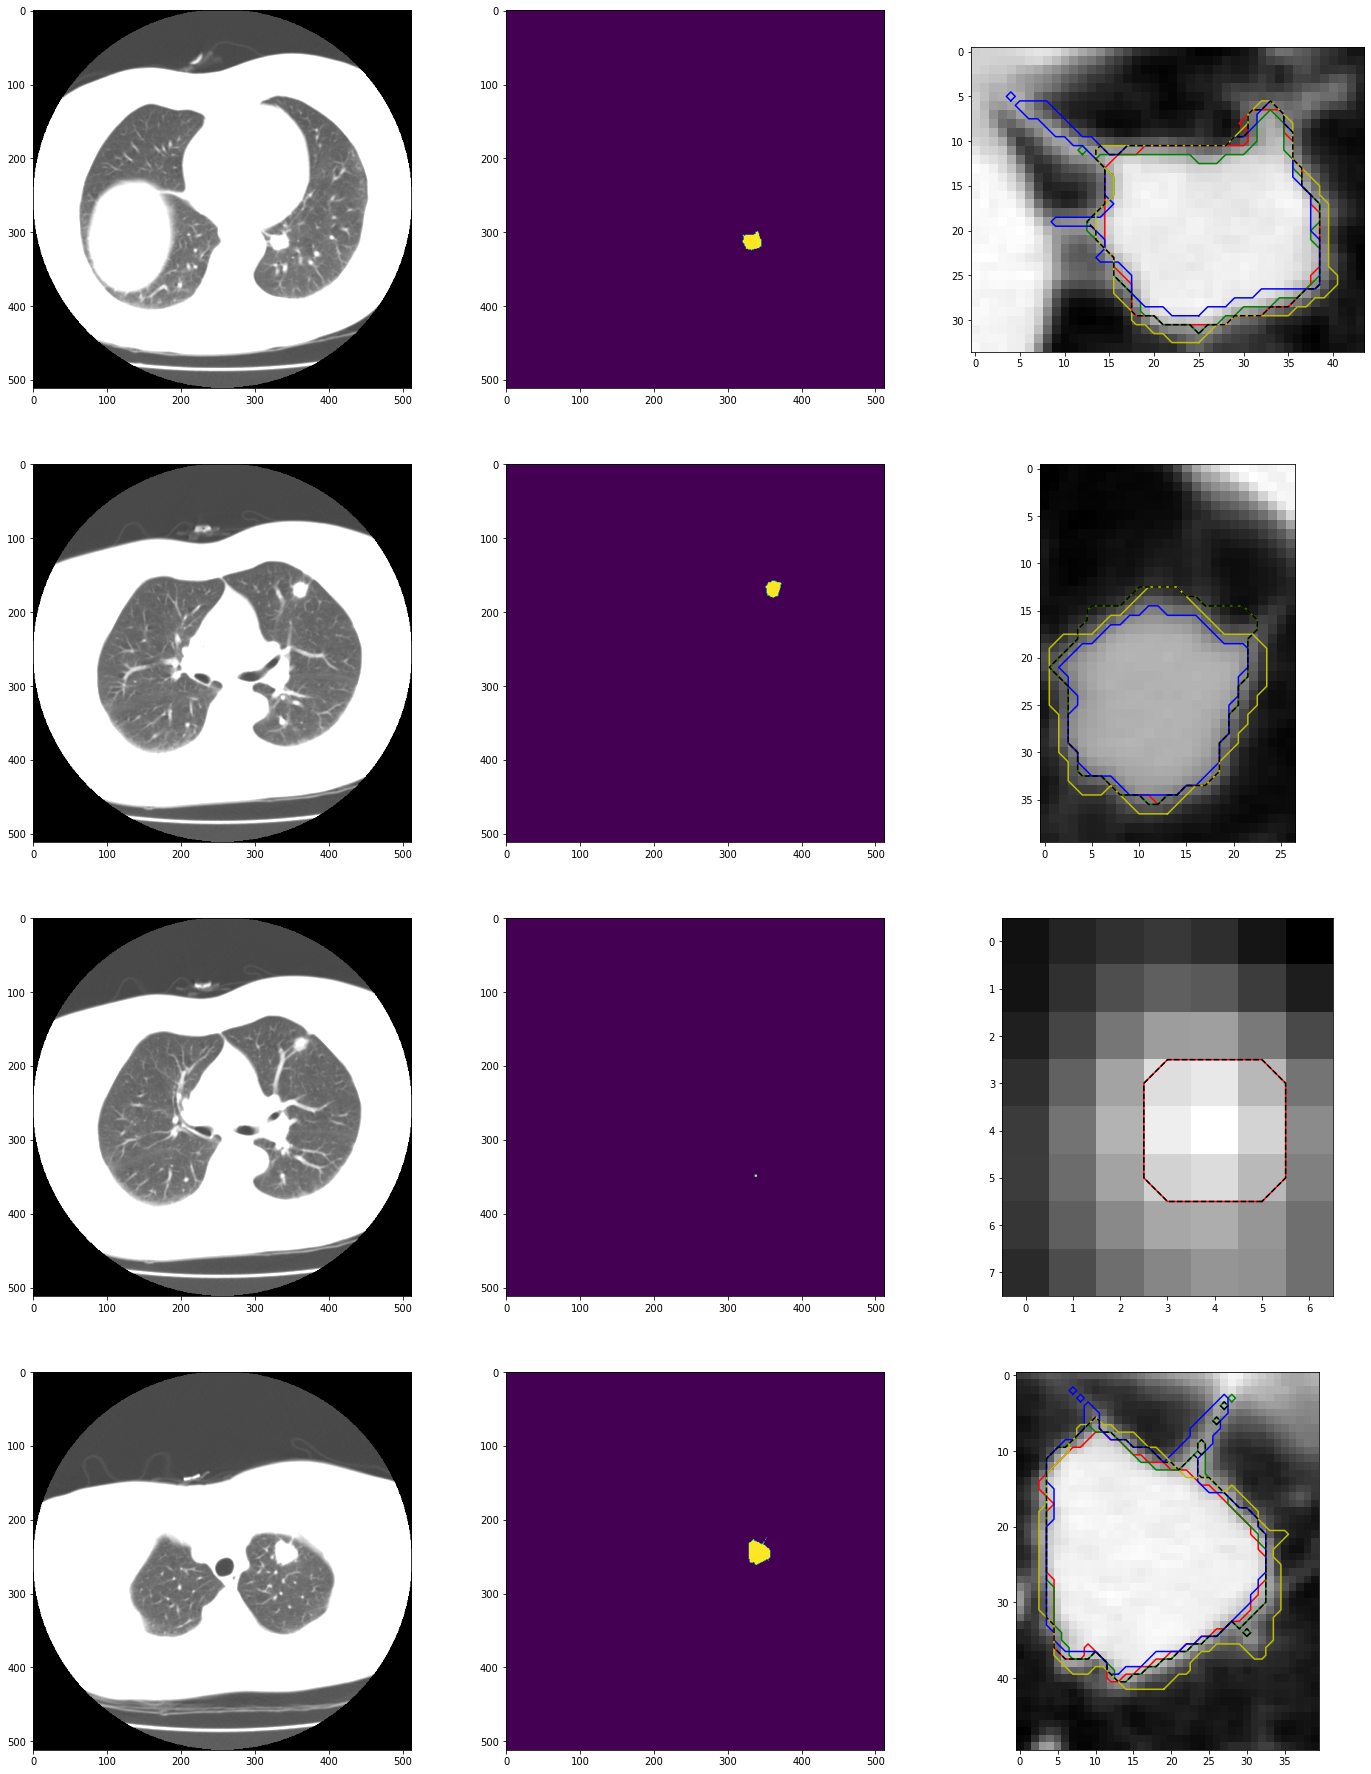

In [7]:
%matplotlib inline

cohort = data_folder
patient_list = os.listdir(cohort)
patient_select = 0

print ("Current patient ID =", patient_list[patient_select])

scan = pl.query(pl.Scan).filter(pl.Scan.patient_id.in_(patient_list))
nodules_annotation = scan[patient_select].cluster_annotations()
vol = scan[patient_select].to_volume()

cmask_CT = []
cbbox_CT = []
masks_CT = []
for nodule_idx, nodule in enumerate(nodules_annotation):
    cmask, cbbox, masks = consensus(nodule)
    cmask_CT.append(cmask)
    cbbox_CT.append(cbbox)
    masks_CT.append(masks)   

nodule_num = len(cmask_CT)
plt.figure(figsize=(8*3,8*nodule_num))
for i in range(nodule_num):
    cmask = cmask_CT[i]
    cbbox = cbbox_CT[i]
    masks = masks_CT[i]
    k = int(0.5*(cbbox[2].stop - cbbox[2].start))
    k_slice = k + cbbox[2].start
    plt.subplot(nodule_num,3,1+i*3)
    plt.imshow(vol[:,:,k_slice],cmap='gray')
    plt.clim(vmin=-1350,vmax=-150)
    
    plt.subplot(nodule_num,3,2+i*3)
    CT_mask = np.zeros_like(vol)
    CT_mask[cbbox] = cmask
    plt.imshow(CT_mask[:,:,k_slice])

    plt.subplot(nodule_num,3,3+i*3)
    plt.imshow(vol[cbbox][:,:,k],cmap='gray')
    # Plot the annotation contours for the kth slice.
    colors = ['r', 'g', 'b', 'y']
    for j in range(len(masks)):
        for c in find_contours(masks[j][:,:,k].astype(float), 0.5):
            label = "Annotation %d" % (j+1)
            plt.plot(c[:,1], c[:,0], colors[j], label=label)

    # Plot the 50% consensus contour for the kth slice.
    for c in find_contours(cmask[:,:,k].astype(float), 0.5):
        plt.plot(c[:,1], c[:,0], '--k', label='50% Consensus')

### Prepare the dataset, shuffle and sub-sample

In [4]:
# will keep the test set for hold out, we need to get the val set generated from train files so that we can shuffle well
train_images_path =  '/data/all/train/images'
file_list = os.listdir(train_images_path)
print(len(file_list))

208836


In [5]:
val_ratio = 0.2
SEED = 2021
random.seed(SEED)
#file_list = [i for i in range(len(patient_list))]
num_files = len(file_list)
idxs = np.arange(num_files)
random.shuffle(idxs)
train_image_files = np.array(file_list)[idxs][:int(num_files*(1-val_ratio))]
train_mask_files = [fn.replace('img','mask') for fn in train_image_files]

val_image_files = np.array(file_list)[idxs][int(num_files*(1-val_ratio)):]
val_mask_files = [fn.replace('img','mask') for fn in val_image_files]

#### Use only a fraction of the training samples

In [6]:
# use only a subset of the images, to test the model first
num_tr_files = len(train_image_files)
num_val_files = len(val_image_files)
frac = 0.01 # use only 10% of samples
train_image_files = train_image_files[:int(num_tr_files*frac)]
train_mask_files = train_mask_files[:int(num_tr_files*frac)]
val_image_files = val_image_files[:int(num_val_files*frac)]
val_mask_files = val_mask_files[:int(num_val_files*frac)]

In [7]:
print("Training samples {} and val samples {}".format(len(train_image_files), len(val_image_files)))

Training samples 1670 and val samples 417


In [8]:
[(img, msk) for img, msk in zip(train_image_files[:5], train_mask_files[:5])]

[('img_LIDC-IDRI-0450_114.npz', 'mask_LIDC-IDRI-0450_114.npz'),
 ('img_LIDC-IDRI-0886_27.npz', 'mask_LIDC-IDRI-0886_27.npz'),
 ('img_LIDC-IDRI-0486_64.npz', 'mask_LIDC-IDRI-0486_64.npz'),
 ('img_LIDC-IDRI-0791_92.npz', 'mask_LIDC-IDRI-0791_92.npz'),
 ('img_LIDC-IDRI-0407_88.npz', 'mask_LIDC-IDRI-0407_88.npz')]

### Torch data loader

In [9]:
class nodule_data(Dataset):
    def __init__(self,image_paths,mask_paths):
        super().__init__()
        self.image_paths = image_paths
        self.mask_paths  = mask_paths
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        
        image = np.load('/data/all/train/images/' + self.image_paths[index])['arr_0'].astype('float32')
        mask  = np.load('/data/all/train/masks/' + self.mask_paths[index])['arr_0'].astype('float32')
        image -= np.mean(image)
        image /= np.std(image)

        return image[np.newaxis,:], mask[np.newaxis,:]

batch_size  = 4
num_workers = 4
nodule_data_train = nodule_data(train_image_files, train_mask_files)
nodule_data_val   = nodule_data(val_image_files, val_mask_files)

train_loader = DataLoader(nodule_data_train, batch_size = batch_size,
                             num_workers = num_workers)

val_loader   = DataLoader(nodule_data_val, batch_size = batch_size,
                             num_workers = num_workers)

#### Define the model

In [10]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding = 1)
        self.relu1 = nn.ReLU()
        self.bn1   = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding = 1)
        self.relu2 = nn.ReLU()
        self.bn2   = nn.BatchNorm2d(out_ch)
    
    def forward(self, x):
        return self.bn2(self.relu2(self.conv2(self.bn1(self.relu1(self.conv1(x))))))
    

class Encoder(nn.Module):
    def __init__(self, chs=(1,32,64,128,256)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs


class Decoder(nn.Module):
    def __init__(self, chs=(256, 128, 64, 32)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
#            enc_ftrs = self.crop(encoder_features[i], x)
#            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = torch.cat([x, encoder_features[i]], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    
#    def crop(self, enc_ftrs, x):
#        _, _, H, W = x.shape
#        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
#        return enc_ftrs
    


class Unet(nn.Module):
    def __init__(self, enc_chs=(1,32,64,128,256), dec_chs=(256, 128, 64, 32), num_class=1, retain_dim=False, out_sz=(512,512)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, out_sz)
        return out

In [11]:
print(torch.__version__)
print("Number of GPUs =", torch.cuda.device_count())

1.10.0a0+3fd9dcf
Number of GPUs = 4


In [12]:
dataiter = iter(train_loader)
images,labels=dataiter.next()
images.dtype

torch.float32

In [13]:
print(labels.shape)
print(images[0].shape)

torch.Size([4, 1, 512, 512])
torch.Size([1, 512, 512])


#### Set up the model to use all GPUs

In [14]:
model = Unet()
model = torch.nn.parallel.DataParallel(model, device_ids=[0,1,2,3]).cuda()

In [15]:
device = torch.device("cuda")

In [16]:
#torch.distributed.init_process_group(backend="nccl")
#device = torch.device("cuda:0")
# device = torch.device("cuda")
# #device = torch.device("**cuda:0**" if torch.cuda.is_available() else "cpu")
# #model = Unet()
# #torch.nn.DataParallel(model, device_ids=[0, 1, 2, 3])
# model = nn.DataParallel(Unet()).to(device)
# summary(model,(1,512,512))

In [17]:
#!mkdir saved_model

In [18]:
#model = torch.nn.DataParallel(model, device_ids=[0, 1, 2, 3])

#### Run training

In [35]:
num_epochs = 30
criterion  = nn.BCEWithLogitsLoss()
optimizer  = torch.optim.Adam(model.parameters(),0.0001)


train_loss = []
val_loss   = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    start = time.time()
    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    running_loss /= i+1
    train_loss.append(running_loss)
    end = time.time()
    print(f"Epoch {epoch} trained with loss: {running_loss}. The running time is {end-start}.")
    
    model.eval()
    running_loss = 0.0
    running_score = 0.0
    start = time.time()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            score = dice_coef(outputs, labels)
            running_score += score
    running_loss /= i+1
    running_score /= i+1
    val_loss.append(running_loss)
    end = time.time()
    print(f"Epoch {epoch} evaluated with loss: {running_loss}, and dice score: {running_score}. The running time is {end-start}.")
    
    #if running_loss == min(val_loss):
    PATH = f'saved_model/Epoch{epoch}.pth'
    torch.save(model.state_dict(),PATH)
    print('Best model saved at epoch:', epoch)

print("Training is completed.")

Epoch 0 trained with loss: 0.5200745953184566. The running time is 41.60205030441284.
Epoch 0 evaluated with loss: 0.44274124815350485, and dice score: 7.073361484799534e-05. The running time is 4.402588605880737.
Best model saved at epoch: 0
Epoch 1 trained with loss: 0.3665268096769826. The running time is 40.90353751182556.
Epoch 1 evaluated with loss: 0.29370112759726386, and dice score: 7.116610504454002e-05. The running time is 4.327732801437378.
Best model saved at epoch: 1
Epoch 2 trained with loss: 0.23621426700975337. The running time is 40.92471790313721.
Epoch 2 evaluated with loss: 0.18453406535443806, and dice score: 7.097318302839994e-05. The running time is 4.272554874420166.
Best model saved at epoch: 2
Epoch 3 trained with loss: 0.14712392823975623. The running time is 40.83727478981018.
Epoch 3 evaluated with loss: 0.11503392110268275, and dice score: 7.085721153998747e-05. The running time is 4.387934923171997.
Best model saved at epoch: 3
Epoch 4 trained with loss:

KeyboardInterrupt: 

In [22]:
labels

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
    

In [20]:
# def dice_coef(y_true, y_pred):
#     y_true_f = y_true.flatten()
#     y_pred_f = y_pred.flatten()
#     intersection = np.sum(y_true_f * y_pred_f)
#     smooth = 0.0001
#     return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

In [33]:
def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = (y_true_f * y_pred_f).sum()
    smooth = 0.0001
    return (2. * intersection + smooth) / ((y_true_f).sum() + (y_pred_f).sum() + smooth)

In [34]:
dice_coef(outputs, labels)

tensor(-4.5728e-10, device='cuda:0', grad_fn=<DivBackward0>)

In [28]:
y_true_f = outputs.flatten()
y_pred_f = labels.flatten()
#intersection = np.sum(y_true_f * y_pred_f)

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')

In [32]:
y_true_f.sum() + y_pred_f.sum()

tensor(-218685.6719, device='cuda:0', grad_fn=<AddBackward0>)

In [30]:
(y_true_f * y_pred_f).sum()

tensor(0., device='cuda:0', grad_fn=<SumBackward0>)

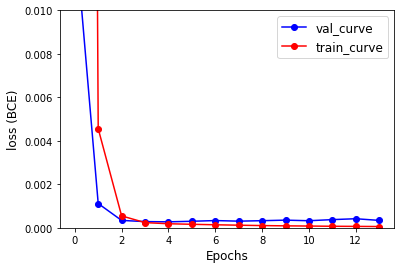

In [47]:
%matplotlib inline
epochs = range(len(val_loss))
plt.figure()
plt.plot(epochs, val_loss,'bo-', label = 'val_curve')
plt.plot(epochs,train_loss,'ro-', label = 'train_curve')
plt.ylim([0,0.01])
plt.xlabel('Epochs', fontsize= 12)
plt.ylabel('loss (BCE)', fontsize = 12)
plt.legend(fontsize = 12)

#### Check how well we are predicting

Current patient ID = LIDC-IDRI-0086
Loading dicom files ... This may take a moment.


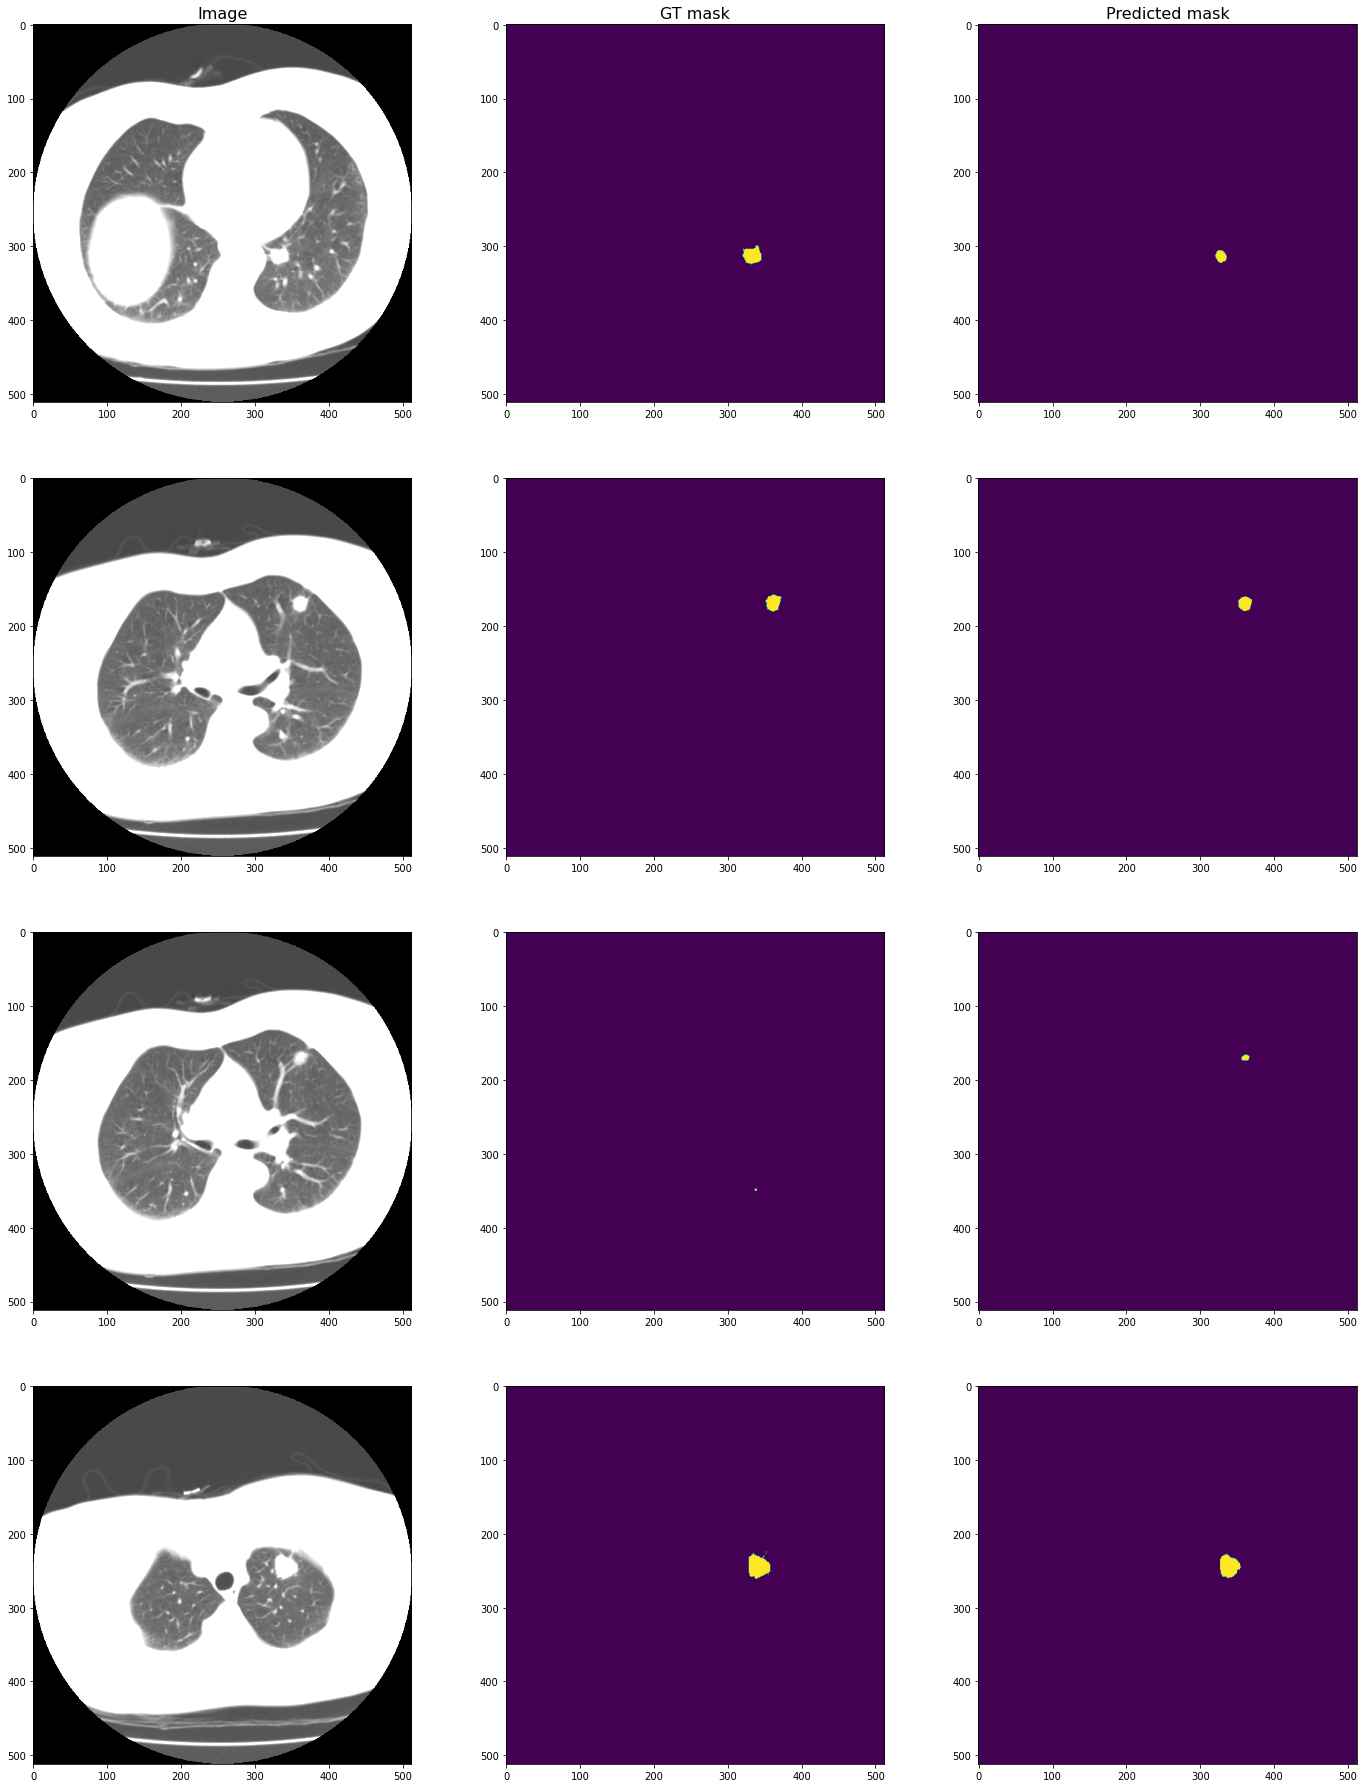

In [48]:
%matplotlib inline

cohort = data_folder
patient_list = os.listdir(cohort)
patient_select = 0

print ("Current patient ID =", patient_list[patient_select])

scan = pl.query(pl.Scan).filter(pl.Scan.patient_id.in_(patient_list))
nodules_annotation = scan[patient_select].cluster_annotations()
vol = scan[patient_select].to_volume()

cmask_CT = []
cbbox_CT = []
masks_CT = []
for nodule_idx, nodule in enumerate(nodules_annotation):
    cmask, cbbox, masks = consensus(nodule)
    cmask_CT.append(cmask)
    cbbox_CT.append(cbbox)
    masks_CT.append(masks)   

nodule_num = len(cmask_CT)
plt.figure(figsize=(8*3,8*nodule_num))
for i in range(nodule_num):
    cmask = cmask_CT[i]
    cbbox = cbbox_CT[i]
    masks = masks_CT[i]
    k = int(0.5*(cbbox[2].stop - cbbox[2].start))
    k_slice = k + cbbox[2].start
    plt.subplot(nodule_num,3,1+i*3)
    plt.imshow(vol[:,:,k_slice],cmap='gray')
    plt.clim(vmin=-1350,vmax=-150)
    if i==0:
        plt.title('Image',fontsize=16)
    
    plt.subplot(nodule_num,3,2+i*3)
    CT_mask = np.zeros_like(vol)
    CT_mask[cbbox] = cmask
    plt.imshow(CT_mask[:,:,k_slice])
    if i==0:
        plt.title('GT mask',fontsize=16)

    plt.subplot(nodule_num,3,3+i*3)
    image = vol[:,:,k_slice].astype('float32')
    image -= np.mean(image)
    image /= np.std(image)
    image = torch.from_numpy(image[np.newaxis,np.newaxis,:]).to(device)
    mask_pre = torch.sigmoid(model(image)).detach().cpu().numpy()
    mask_pre = np.squeeze(mask_pre)
  #  print(np.max(mask_pre), np.min(mask_pre))
  #  print(np.max(CT_mask[:,:,k_slice]), np.min(CT_mask[:,:,k_slice]))
    mask_pre = np.where(mask_pre>0.5, 1,0)
    plt.imshow(mask_pre)
    if i==0:
        plt.title('Predicted mask',fontsize=16)

## Backup

In [45]:
CT_image_data = []
CT_mask_data  = []

for pa in range(len(patient_list)):
    print ("Current patient ID =", patient_list[pa])
    
    scan = pl.query(pl.Scan).filter(pl.Scan.patient_id.in_(patient_list))
    nodules_annotation = scan[pa].cluster_annotations()
    vol = scan[pa].to_volume()
    
    CT_image_data.append(vol)
    
    cmask_CT = []
    cbbox_CT = []
    masks_CT = []
    for nodule_idx, nodule in enumerate(nodules_annotation):
        cmask, cbbox, masks = consensus(nodule)
        cmask_CT.append(cmask)
        cbbox_CT.append(cbbox)
        masks_CT.append(masks)   

    CT_mask = np.zeros_like(vol)    
    nodule_num = len(cmask_CT)
    
    for i in range(nodule_num):
        cmask = cmask_CT[i]
        cbbox = cbbox_CT[i]
        masks = masks_CT[i]    
        CT_mask[cbbox] += cmask
        
    CT_mask_data.append(CT_mask)

Current patient ID = LIDC-IDRI-0086
Loading dicom files ... This may take a moment.
Current patient ID = LIDC-IDRI-0095
Loading dicom files ... This may take a moment.
Current patient ID = LIDC-IDRI-0298
Loading dicom files ... This may take a moment.
Current patient ID = LIDC-IDRI-0101
Loading dicom files ... This may take a moment.
Current patient ID = LIDC-IDRI-0300
Loading dicom files ... This may take a moment.
Current patient ID = LIDC-IDRI-0106
Loading dicom files ... This may take a moment.
Current patient ID = LIDC-IDRI-0314
Loading dicom files ... This may take a moment.
Current patient ID = LIDC-IDRI-0094
Loading dicom files ... This may take a moment.
Current patient ID = LIDC-IDRI-0325
Loading dicom files ... This may take a moment.
Current patient ID = LIDC-IDRI-0069
Loading dicom files ... This may take a moment.
Current patient ID = LIDC-IDRI-0098
Loading dicom files ... This may take a moment.
Current patient ID = LIDC-IDRI-0084
Loading dicom files ... This may take a 

In [47]:
i = 0 
for j in range(CT_image_data[i].shape[2]):
        image_npfile = train_image_root+str(i)+'-'+str(j)+'.npy'
        mask_npfile  = train_mask_root+str(i)+'-'+str(j)+'.npy'
        np.save(image_npfile, CT_image_data[i][:,:,j][np.newaxis,:])
        np.save(mask_npfile, CT_mask_data[i][:,:,j][np.newaxis,:])

SyntaxError: invalid syntax (3681721142.py, line 6)

In [50]:
CT_mask_data[0][:,:,0][np.newaxis,:].shape

(1, 512, 512)

In [58]:
for i, data in enumerate(train_loader):
    print(data.shape)
    break

AttributeError: 'list' object has no attribute 'shape'

In [65]:
data[0]

tensor([[[-1.7940, -1.7940, -1.7940,  ..., -1.7940, -1.7940, -1.7940],
         [-1.7940, -1.7940, -1.7940,  ..., -1.7940, -1.7940, -1.7940],
         [-1.7940, -1.7940, -1.7940,  ..., -1.7940, -1.7940, -1.7940],
         ...,
         [-1.7940, -1.7940, -1.7940,  ..., -1.7940, -1.7940, -1.7940],
         [-1.7940, -1.7940, -1.7940,  ..., -1.7940, -1.7940, -1.7940],
         [-1.7940, -1.7940, -1.7940,  ..., -1.7940, -1.7940, -1.7940]],

        [[-0.9297, -0.9297, -0.9297,  ..., -0.9297, -0.9297, -0.9297],
         [-0.9297, -0.9297, -0.9297,  ..., -0.9297, -0.9297, -0.9297],
         [-0.9297, -0.9297, -0.9297,  ..., -0.9297, -0.9297, -0.9297],
         ...,
         [-0.9297, -0.9297, -0.9297,  ..., -0.9297, -0.9297, -0.9297],
         [-0.9297, -0.9297, -0.9297,  ..., -0.9297, -0.9297, -0.9297],
         [-0.9297, -0.9297, -0.9297,  ..., -0.9297, -0.9297, -0.9297]],

        [[-1.4881, -1.4881, -1.4732,  ..., -1.4456, -1.4477, -1.4222],
         [-1.4881, -1.4881, -1.4647,  ..., -1

Current patient ID = LIDC-IDRI-0086
Loading dicom files ... This may take a moment.


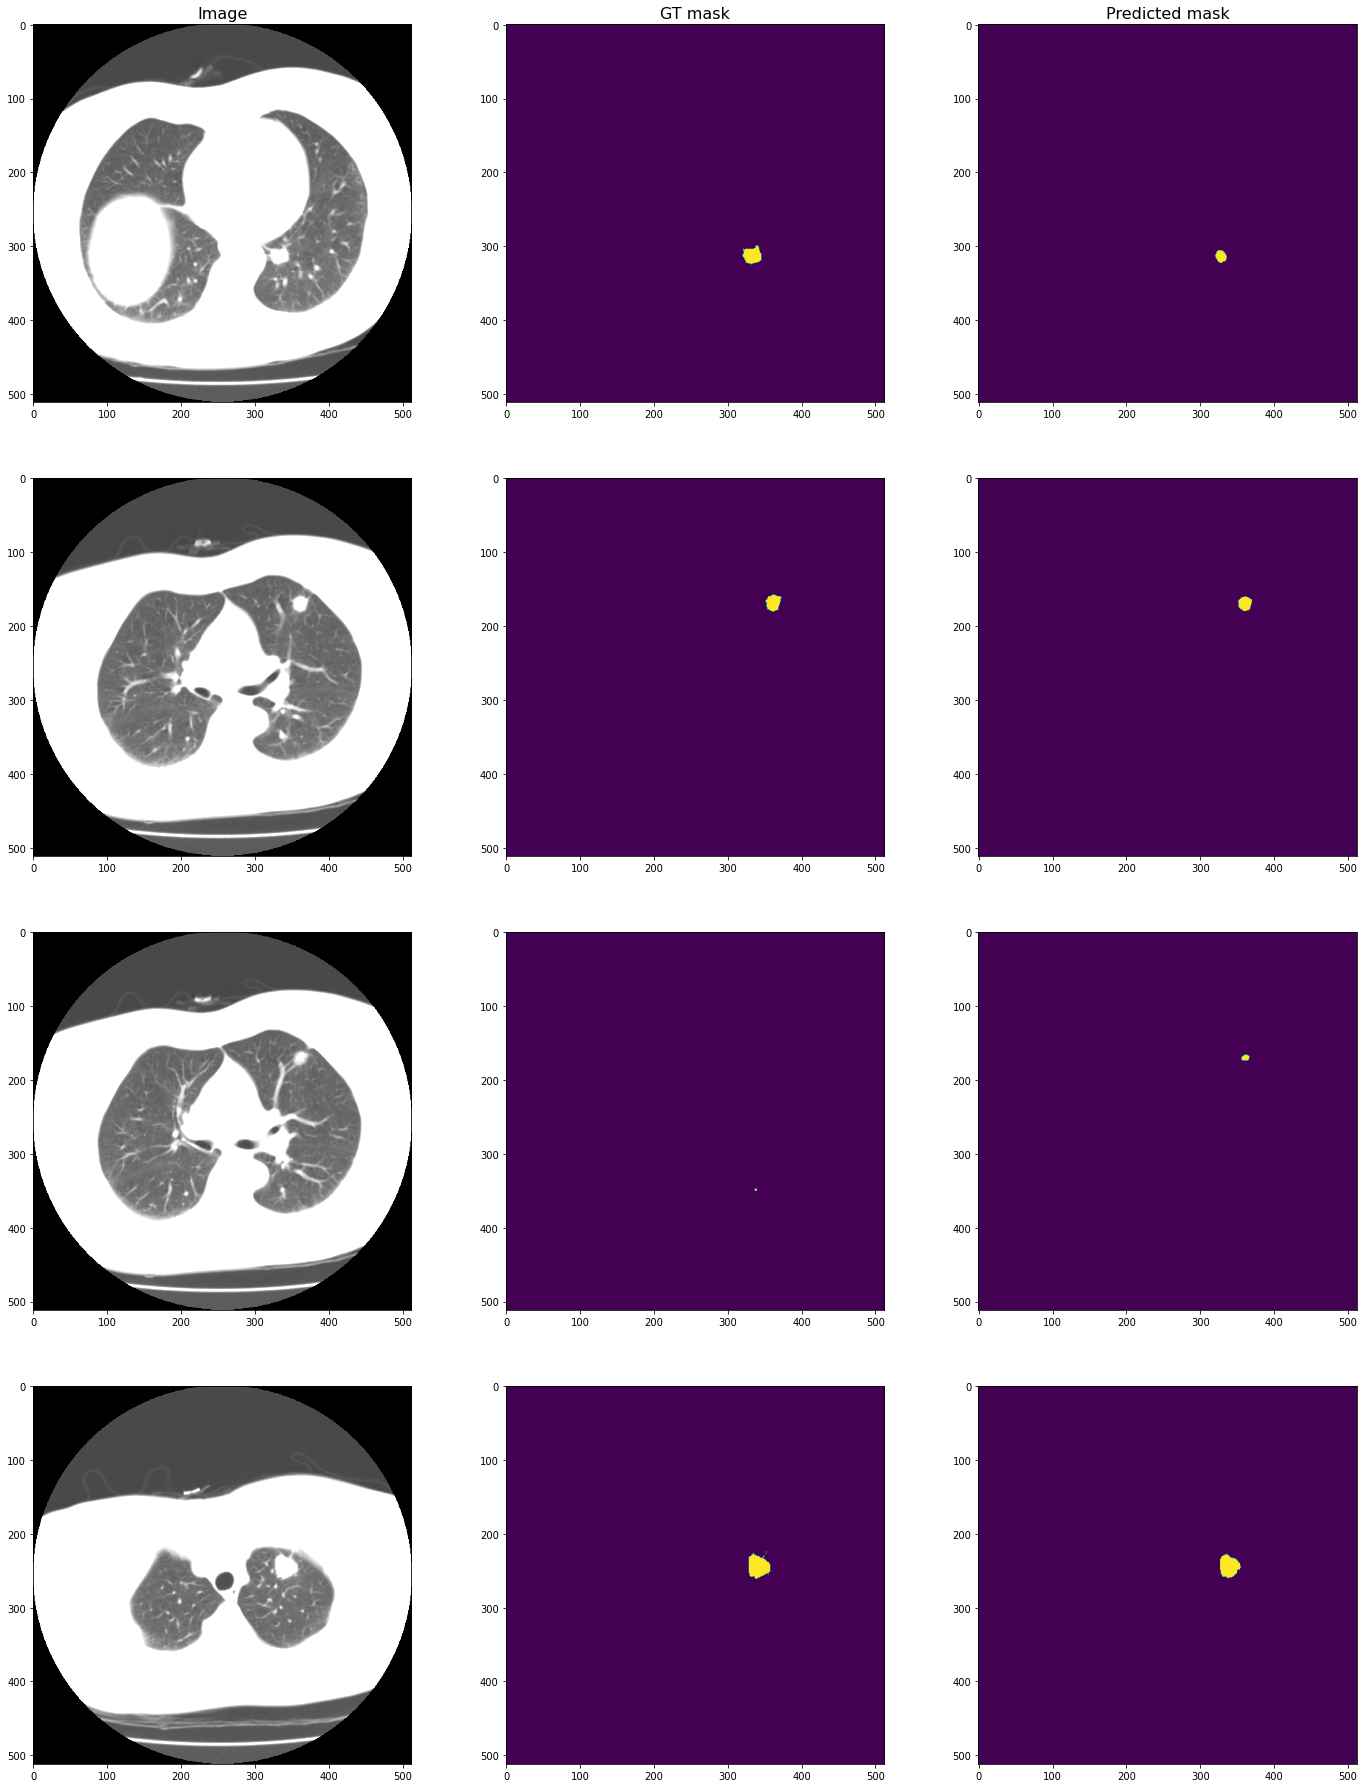

In [39]:
%matplotlib inline

cohort = data_folder
patient_list = os.listdir(cohort)
patient_select = 0

print ("Current patient ID =", patient_list[patient_select])

scan = pl.query(pl.Scan).filter(pl.Scan.patient_id.in_(patient_list))
nodules_annotation = scan[patient_select].cluster_annotations()
vol = scan[patient_select].to_volume()

cmask_CT = []
cbbox_CT = []
masks_CT = []
for nodule_idx, nodule in enumerate(nodules_annotation):
    cmask, cbbox, masks = consensus(nodule)
    cmask_CT.append(cmask)
    cbbox_CT.append(cbbox)
    masks_CT.append(masks)   

nodule_num = len(cmask_CT)
plt.figure(figsize=(8*3,8*nodule_num))
for i in range(nodule_num):
    cmask = cmask_CT[i]
    cbbox = cbbox_CT[i]
    masks = masks_CT[i]
    k = int(0.5*(cbbox[2].stop - cbbox[2].start))
    k_slice = k + cbbox[2].start
    plt.subplot(nodule_num,3,1+i*3)
    plt.imshow(vol[:,:,k_slice],cmap='gray')
    plt.clim(vmin=-1350,vmax=-150)
    if i==0:
        plt.title('Image',fontsize=16)
    
    plt.subplot(nodule_num,3,2+i*3)
    CT_mask = np.zeros_like(vol)
    CT_mask[cbbox] = cmask
    plt.imshow(CT_mask[:,:,k_slice])
    if i==0:
        plt.title('GT mask',fontsize=16)

    plt.subplot(nodule_num,3,3+i*3)
    image = vol[:,:,k_slice].astype('float32')
    image -= np.mean(image)
    image /= np.std(image)
    image = torch.from_numpy(image[np.newaxis,np.newaxis,:]).to(device)
    mask_pre = torch.sigmoid(model(image)).detach().cpu().numpy()
    mask_pre = np.squeeze(mask_pre)
  #  print(np.max(mask_pre), np.min(mask_pre))
  #  print(np.max(CT_mask[:,:,k_slice]), np.min(CT_mask[:,:,k_slice]))
    mask_pre = np.where(mask_pre>0.5, 1,0)
    plt.imshow(mask_pre)
    if i==0:
        plt.title('Predicted mask',fontsize=16)